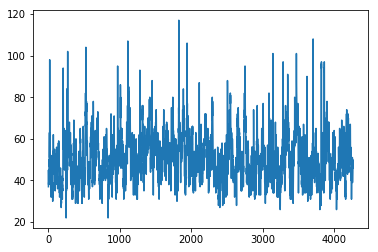

3466712
average = 38.759036516445555
coverage = 1.0


In [2]:
#Genome coverage (graph, percentage of genome covered, average coverage)

import pysam
import pyBigWig
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

bw_1000_f = 'pacbio_40x_1000.bw'
bw_1_f = 'pacbio_40x.bw'
bam_f = 'pacbio_40x_MD.sam'

bw_1000 = open('/Users/dashabalashova/ngs_institute/HW3/'+bw_1000_f, 'r')
a = []
for r in bw_1000.read().splitlines():
    a.append(int(r.split('\t')[-1]))

plt.figure()
plt.plot(a)
plt.show()

bw = open('/Users/dashabalashova/ngs_institute/HW3/'+bw_1_f, 'r')
a = []
N = 0
for r in bw.read().splitlines():
    a.append(int(r.split('\t')[-1]))
    N += 1
    
print(N)

print('average =', np.mean(a))
print('coverage =', (len(a)-a.count(0))/len(a))

In [28]:
#Table of frequencies of replacements / insertions / deletions and and lengths of indels hist


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
old_stdout = sys.stdout


bamfile = pysam.AlignmentFile(bam_f, 'rb')

a = np.array([[0,0,0,0,0],
              [0,0,0,0,0],
              [0,0,0,0,0],
              [0,0,0,0,0],
              [0,0,0,0,0]])

frame = pd.DataFrame(a, index=['A','C','G','T','-'], columns=['A','C','G','T','-'])

N = 0
indel = []

insertion_s = ''
deletion_s = ''
mism_read_s = ''
mism_ref_s = ''
indels_lengths = []
M = 0
N = 0
#print(len(bamfile.fetch()))
import time
t_st = time.clock()
for alignment in bamfile.fetch():
    N+=1
    
    if alignment.cigarstring!=None and str(alignment).split()[9]!='None':
        read = alignment.query_sequence
        
        t = time.clock()
        if N%1000==0:
            
        
            log_file = open("message.log","w")   
            sys.stdout = log_file
            print("this will be written to message.log", N,(time.clock()-t_st)/(N+1)*3466712/60)
            sys.stdout = old_stdout
            log_file.close() 

            if N%5000==0: 
                t = time.clock()
                
            
                for n in range(0,len(mism_read_s)):
                    frame[mism_ref_s[n].upper()][mism_read_s[n]] += 1
         
                for l in ['A','C','T','G']:
                    frame['-'][l] += insertion_s.count(l)
            
                for l in ['A','C','T','G']:
                    frame[l]['-'] += deletion_s.count(l)
           

                insertion_s = ''
                deletion_s = ''
                mism_read_s = ''
                mism_ref_s = ''
            
        ref = alignment.get_reference_sequence()
        mapping = alignment.get_aligned_pairs(matches_only=True, with_seq=True)

    
        n_read = 0
        n_ref = 0
        
        for i in alignment.cigar:
            
            if i[0]==4: #start_insertion
                insertion_s += read[n_read:n_read+i[1]]
                indels_lengths.append(i[1])
                n_read += i[1]
            
            if i[0]==0: #match
                for n in range(0,i[1]):
                    if ref[n_ref:n_ref+i[1]][n].islower()==True:
                        mism_read_s+=read[n_read:n_read+i[1]][n]
                        mism_ref_s+=ref[n_ref:n_ref+i[1]][n]
                n_read += i[1]
                n_ref += i[1]
                         
            if i[0]==1: #BAM_CINS
                insertion_s += read[n_read:n_read+i[1]]
                indels_lengths.append(i[1])
                n_read += i[1]
                
            if i[0]==2: #BAM_CDEL
                deletion_s += ref[n_ref:n_ref+i[1]]
                indels_lengths.append(i[1])
                n_ref += i[1]
                             
                
for n in range(0,len(mism_read_s)):
    frame[mism_ref_s[n].upper()][mism_read_s[n]] += 1       

for i in insertion_s:
    frame['-'][i] += 1

for i in deletion_s:
    frame[i]['-'] += 1

print(frame)



         A        C        G        T         -
A        0   457338   322254   285699  11336139
C   354487        0   415583   309393  11848128
G   307539   414331        0   359744  11880353
T   285427   321990   450152        0  11332873
-  1439867  2074963  2067558  1436033         0


In [26]:
#lengths of indels: 1_column length, 2_column count

s = 0
for i in list(set(indels_lengths))[:30]:
    print(i, indels_lengths.count(i))
    s += indels_lengths.count(i)
print('>30', len(indels_lengths)-s)


1 13025156
2 2330680
3 606050
4 229055
5 110064
6 60235
7 37277
8 24278
9 16677
10 12292
11 9105
12 6878
13 5312
14 4030
15 3195
16 2504
17 1937
18 1582
19 1241
20 990
21 1051
22 1016
23 934
24 912
25 926
26 830
27 793
28 761
29 693
30 673
>30 29384


In [16]:
#Статистика дин инделов в завимости от длины гомополимерного участка на примере 'AAAAA'

import pysam
import re


def find(sst, st):
    st = st.upper()
    u = [m.start() for m in re.finditer(sst, st)]
    u2 = []
    for n in range(0,len(u)):      
        if u[n]+len(sst)>=len(st):
            u2.append(u[n])
        elif st[u[n]+len(sst)]!=sst[0]:
            u2.append(u[n])
    return u2

def map_f(mapping, read, position, sst):
    u=[]
    R = mapping[0][1]
    for m in mapping:
        if m[1] in range(position+R, position+len(sst)+R):
            u.append(m[0])
    if u==[]:
        return 'N'
    s1 = 0
    s2 = 0
    while (max(u)+1<len(read) and s1==0):
        if read[max(u)+1]==gomo[0]:
            u.append(max(u)+1)
        else:
            s1=1
    while (min(u)-1>=0 and s2==0):
        if read[min(u)-1]==gomo[0]:
            u.append(min(u)-1)
        else:
            s2=1           
    return read[min(u):max(u)+1] 

def ch(st):
    n=25
    while n>0:
        if st.count('A'*n)>0:
            return 'A'*n
        else:
            n-=1
    return ''

samfile = pysam.AlignmentFile(bam_f, "rb")
n=0
g_arr = []
gomo = 'AAAAA'
for alignment in samfile.fetch():    
    if alignment.cigarstring!=None and str(alignment).split()[9]!='None':
        mapping = alignment.get_aligned_pairs(matches_only=True, with_seq=True)
        read = alignment.query_sequence
        ref = alignment.get_reference_sequence()
        for p in find(gomo, ref):
            a = map_f(mapping, read, p, gomo)
            g_arr.append(ch(a))    
        n+=1


for a in sorted(set(g_arr)):
    if a!='':
        print(a, g_arr.count(a))

A 1405
AA 7811
AAA 23386
AAAA 47267
AAAAA 122926
AAAAAA 23269
AAAAAAA 4519
AAAAAAAA 1249
AAAAAAAAA 462
AAAAAAAAAA 219
AAAAAAAAAAA 92
AAAAAAAAAAAA 60
AAAAAAAAAAAAA 28
AAAAAAAAAAAAAA 27
AAAAAAAAAAAAAAA 9
AAAAAAAAAAAAAAAA 3
AAAAAAAAAAAAAAAAA 7
AAAAAAAAAAAAAAAAAA 3
AAAAAAAAAAAAAAAAAAA 5
AAAAAAAAAAAAAAAAAAAA 2
AAAAAAAAAAAAAAAAAAAAA 2
AAAAAAAAAAAAAAAAAAAAAA 4
AAAAAAAAAAAAAAAAAAAAAAA 1
AAAAAAAAAAAAAAAAAAAAAAAAA 8


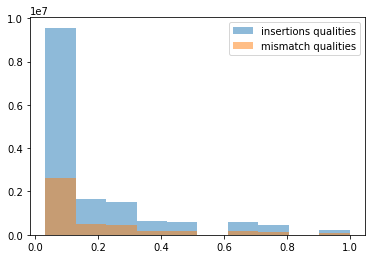

insertion mean percent = 7.63%
mismatch mean percent = 1.93%


In [9]:
#Средний процент ошибок в ридах, Статистика качества нуклеотидов при ошибочно вставленном нуклеотиде и при замене

import pysam
import matplotlib.pyplot as plt
import numpy as np

samfile = pysam.AlignmentFile(bam_f, "rb")
g_arr = []

qual_MIS_num = []
qual_I_num = []
insertion_rate = []
mismatch_rate = []

for alignment in samfile.fetch():
    if alignment.cigarstring!=None and str(alignment).split()[9]!='None':
        read = alignment.query_sequence
        quality = alignment.qual
        ref = alignment.get_reference_sequence()
        count_I = 0
        qual_I = ''
        count_MIS = 0
        qual_MIS = ''
        i_n = 0
        for i in alignment.cigar:
            if i[0]==1:
                count_I+=i[1]
                qual_I += quality[i_n:i_n+i[1]]
            i_n += i[1] 

        i_n = 0
        for i in alignment.get_aligned_pairs(matches_only=True, with_seq=True):
            if i[2].islower() == True:
                count_MIS+=1
                qual_MIS_num.append(10**-((ord(quality[i_n])-33)/10.0))
            i_n += 1
            
        for i in qual_I:
            qual_I_num.append(10**-((ord(i)-33)/10.0))
            
        insertion_rate.append(count_I/len(read))
        mismatch_rate.append(count_MIS/len(read))

        

plt.figure(1)
plt.hist(qual_I_num, rwidth = 2, alpha = 0.5, label = "insertions qualities") 
plt.hist(qual_MIS_num, rwidth = 2, alpha = 0.5, label = "mismatch qualities")
plt.legend(loc = 'upper right')
plt.show()
        
print('insertion mean percent =', "{0:.2%}".format(np.mean(insertion_rate)))
print('mismatch mean percent =', "{0:.2%}".format(np.mean(mismatch_rate)))

In [ ]:
Вывод:
    1) в pacbio(по сравнению с Oxford Nanopores) существенно больше "insertion mean percent"
    2) cтатистика дин инделов в завимости от длины гомополимерного участка соизмерима
    3) покрытие соизмеримо